### Scope:
Use pretrained model on COCO dataset

#Create a function that receives the Image as an input

In [ ]:
# import tensorflow as tf 
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 503 kB 56.2 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 3.8 MB 34.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f9cea3e834b946e96fb84eea895178920facdccb9db30488cb88a15a49de5640
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [ ]:
!git clone https://github.com/tensorflow/tpu.git

Cloning into 'tpu'...
remote: Enumerating objects: 10970, done.
remote: Counting objects: 100% (1172/1172), done.
remote: Compressing objects: 100% (598/598), done.
remote: Total 10970 (delta 657), reused 1007 (delta 549), pack-reused 9798
Receiving objects: 100% (10970/10970), 46.77 MiB | 28.29 MiB/s, done.
Resolving deltas: 100% (7695/7695), done.


In [ ]:
import sys
sys.path.insert(0,'tpu/models/official')
sys.path.insert(0,'tpu/models/official/mask_rcnn')


In [ ]:
from IPython import display
from PIL import Image
import numpy as np
import coco_metric
from mask_rcnn.object_detection import visualization_utils


In [ ]:
OUTPUT_LABEL = {
    3:'car',
    8:'truck',
    6:'bus'
}     
category_index = {k: {'id':k, 'name':OUTPUT_LABEL[k]} for k in OUTPUT_LABEL} 

In [ ]:
category_index

{3: {'id': 3, 'name': 'car'},
 8: {'id': 8, 'name': 'truck'},
 6: {'id': 6, 'name': 'bus'}}

In [ ]:

# TPU Configuration
use_tpu = True
import os
import pprint
import tensorflow as tf

TPU_ADDRESS = 'grpc://'+ os.environ['COLAB_TPU_ADDR']
session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
print(session.list_devices())
#session.tf.Session()

[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 1728367062347065816), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 1120286791025486014), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6198456995888464376), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15295036185291981587), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10551610274472441757), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 2639872655613723479), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12765227796167222018), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5331230770246014094), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 5932185569883164408), _DeviceAttributes(/job:tpu_worker/replica:0/tas

In [ ]:
# get the model file
file_location = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
_ = tf.saved_model.loader.load(session, ['serve'],file_location)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


In [ ]:
def process_image(image_path):
  with open(image_path,'rb') as f:
    np_image_string = np.array([f.read()])
  
  # calculate image dimension
  image = Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height,width,3).astype(np.uint8)

  # pass it to model(Pre-trained)
  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0','DetectionBoxes:0','DetectionClasses:0','DetectionScores:0','DetectionMasks:0','ImageInfo:0'], feed_dict={'Placeholder:0':np_image_string}
    )
  # for visualization
  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0,2],axis = (0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis = (0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin,xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax-ymin], axis = -1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks,processed_boxes, height, width)

  image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks = segmentations,
    use_normalized_coordinates = False,
    max_boxes_to_draw = 50,
    min_score_thresh = 0.2
  )
  return image_with_detections

In [ ]:

!wget  https://thumbs.dreamstime.com/z/many-car-street-15244647.jpg -O cars.jpg 

--2022-10-24 00:25:12--  https://thumbs.dreamstime.com/z/many-car-street-15244647.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216842 (212K) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>] 211.76K  --.-KB/s    in 0.03s   

2022-10-24 00:25:12 (6.62 MB/s) - ‘cars.jpg’ saved [216842/216842]



In [ ]:
new_array = process_image('cars.jpg')

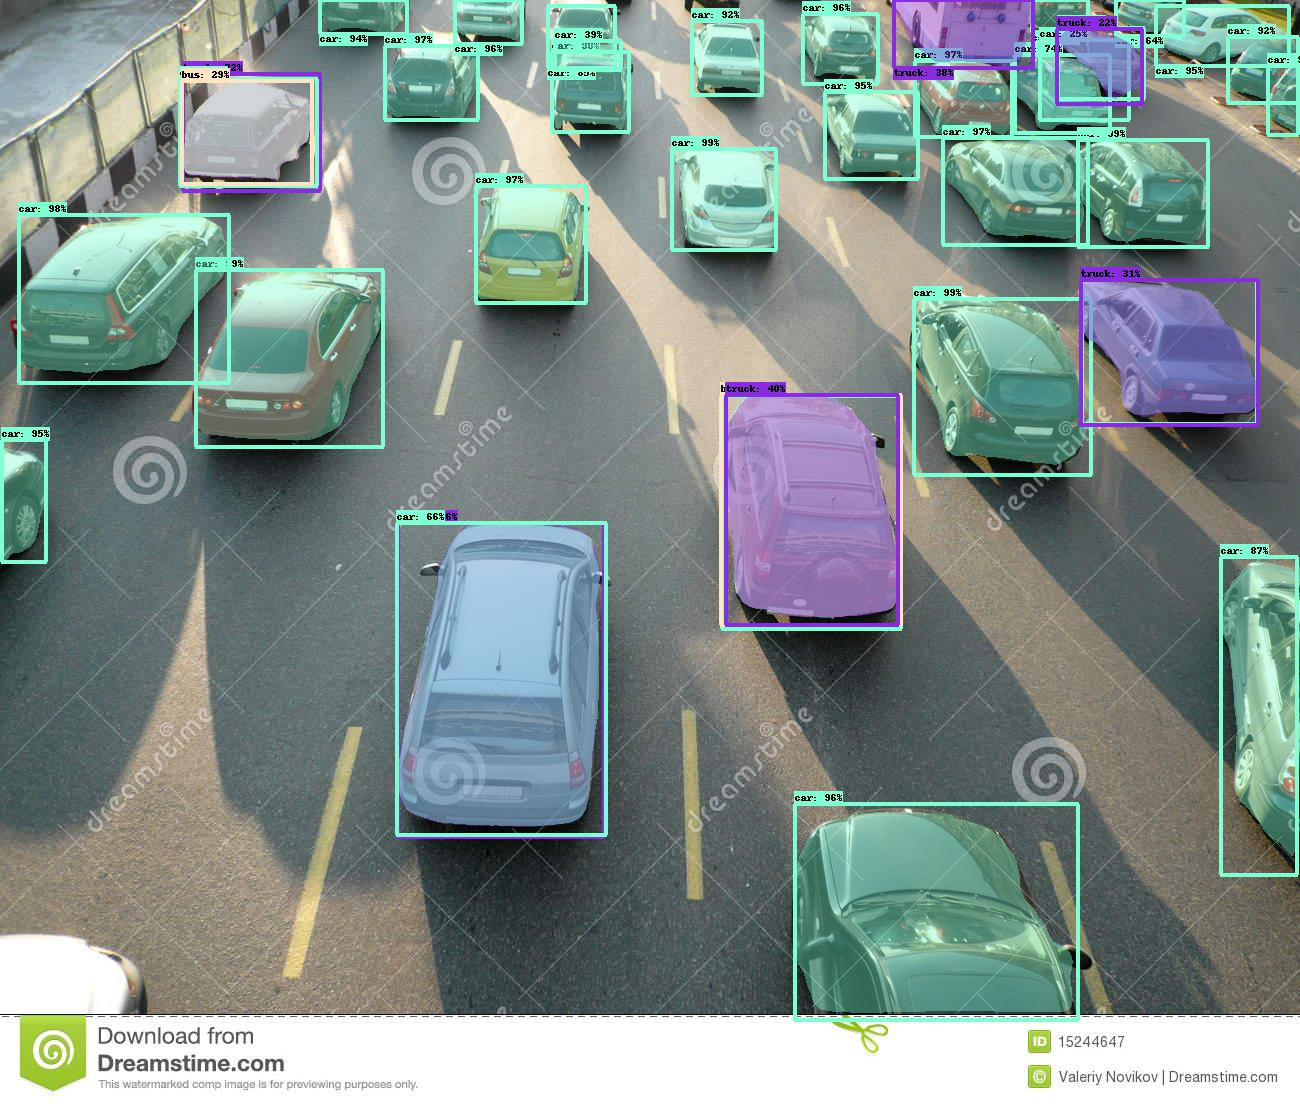

In [ ]:
Image.fromarray(new_array.astype(np.uint8)).save('car_new_123.jpg')
display.display(
    display.Image('car_new_123.jpg', width = 2048)
)

# Split videos into Frames

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

video_path ='/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/Trimmed_video.mp4'
output_img_path ='/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/Splitted_images'
# use opencv to do the job
import cv2
print(cv2.__version__)  # my version is 3.1.0
vidcap = cv2.VideoCapture(video_path)
count = 0
while True:
    success,image = vidcap.read()
    if not success:
        break
    cv2.imwrite(os.path.join(output_img_path,"frame{:d}.jpg".format(count)), image)     # save frame as JPEG file
    count += 1
print("{} images are extacted in {}.".format(count,output_img_path))

4.6.0
1804 images are extacted in /content/gdrive/MyDrive/Colab Notebooks/Neural_Network/Splitted_images.


# Process the images using the function built earlier

In [ ]:

import os
from os import path
# assign directory
# create directory in drive name processed_images in given location

processed_img_path = "/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_images"
if path.exists(processed_img_path) == False:
  os.mkdir(processed_img_path)

splitted_frames ='/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/Splitted_images'
# processed_img_path = '/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_images'

# iterate over files in directory
count = 0
for filename in os.listdir(splitted_frames):
    f = os.path.join(splitted_frames, filename)
    # checking if it is a file
    # if os.path.isfile(f):
    # process the images using the function process_images
    procssd_img = process_image(f)
    Image.fromarray(procssd_img.astype(np.uint8)).save("{}/prsd_frame{:d}.jpg".format(processed_img_path,count))
    console ="{}/prsd_frame{:d}.jpg".format(processed_img_path,count)
    count += 1
    print("Writing:", console)

# Join the images to form the video clip

In [ ]:
processed_img_path = "/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_images"
import os
lst = os.listdir(processed_img_path) # your directory path
number_files = len(lst)
print ("number_files",number_files)


number_files 1816


In [ ]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



# print len([name for name in os.listdir('.') if os.path.isfile(name)])
processed_video_path = "/content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_video"
lst = os.listdir(processed_img_path) # your directory path
number_files = len(lst)

if path.exists(processed_video_path) == False:
  os.mkdir(processed_video_path)

image_files = []

for img_number in range(1,number_files): 
    image_files.append(processed_img_path + '/prsd_frame' + str(img_number) + '.jpg') 

fps = 30

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(processed_video_path + 'new_video.mp4')

[MoviePy] >>>> Building video /content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_videonew_video.mp4
[MoviePy] Writing video /content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_videonew_video.mp4


100%|██████████| 1815/1815 [00:41<00:00, 43.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/Colab Notebooks/Neural_Network/processed_videonew_video.mp4 

